In [1]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, block_diag, identity, hstack, csr_matrix, csc_matrix
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, ieti, algebra, operators
from pyiga import algebra_cy

from scipy.sparse.linalg import aslinearoperator

numpy.set_printoptions(linewidth=100000)
numpy.set_printoptions(precision=5)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
class IetiMapper:
    def __init__(self, MP, dir_data, neu_data=None, elim=False):
        self.space = MP
        self.numpatches = self.space.numpatches
        self.numdofs = self.space.numdofs
        
        kvs = self.space.mesh.kvs
        geos = self.space.mesh.geos

        self.elim=elim

        self.dir_idx = dict()
        self.dir_vals = dict()

        for key in dir_data:
            for p,b in self.mesh.outer_boundaries[key]:
                idx_, vals_ = assemble.compute_dirichlet_bc(kvs[p], geos[p], [(b//2,b%2)], dir_data[key])
                if p in self.dir_idx:
                    self.dir_idx[p].append(idx_)
                    self.dir_vals[p].append(vals_)
                else:
                    self.dir_idx[p]=[idx_]
                    self.dir_vals[p]=[vals_]
                
        for p in self.dir_idx:
            self.dir_idx[p], lookup = np.unique(np.concatenate(self.dir_idx[p]), return_index = True)
            self.dir_vals[p] = np.concatenate(self.dir_vals[p])[lookup]
            
        self.global_dir_idx = np.concatenate([self.dir_idx[p] + self.N_ofs[p] for p in self.dir_idx])

        # if self.elim:
        #     p_intfs = np.array([[p1,p2] for (p1,_,_),(p2,_,_),_ in self.space.intfs], dtype=np.int32).T
        #     self.Basisk, self.N_ofs, self.N, self.B = ieti_cy.pyx_compute_decoupled_coarse_basis(self.space.Basis.tocsc(), MP.N_ofs.astype(np.int32), p_intfs)
        # else:
            #self.Basisk = [scipy.sparse.identity(self.space.N[p]) for p in range(self.space.numpatches)]
        self.B = self.space.B
        self.N = self.space.N
        self.N_ofs = self.space.N_ofs

        self.Bk = [self.B[:,self.N_ofs[p]:self.N_ofs[p+1]] for p in range(self.space.numpatches)]

        nnz_per_col = self.B.getnnz(axis=0)
        self.intfs = np.setdiff1d(np.where(nnz_per_col > 0)[0], self.space.global_dir_idx)
        self.skeleton = np.union1d(self.intfs, self.space.global_dir_idx)
        
        self.R_interior = []
        self.R_skeleton = []
        self.R_interfaces = {}
        
        for p in range(self.space.numpatches):
            Id = scipy.sparse.eye(self.N[p], format='csr')
            mask_skeleton = np.zeros(self.N[p], dtype=bool)
            intfs = np.where(self.Bk[p].getnnz(0) > 0)[0]
            #mask_skeleton[intfs]=True
            mask_interior = np.ones(self.N[p], dtype=bool)
            mask_interior[intfs]=False
            if p in self.dir_idx:
                mask_interior[self.dir_idx[p]]=False
                #mask_skeleton[self.dir_idx[p]]=False
            self.R_interior[p]=Id[mask_interior]
            for b in range(4):
                if not any([(p,b) in self.space.mesh.outer_boundaries[key] for key in self.space.mesh.outer_boundaries]):
                    mask_intf = np.zeros(self.N[p], dtype=bool)
                    interface_dofs = assemble.boundary_dofs(kvs[p],bdspec=[(b//2,b%2)],ravel=True)
                    mask_intf[interface_dofs] = True
                    if p in self.dir_idx:
                        mask_intf[self.dir_idx[p]]=False
                    mask_skeleton += mask_intf
                    self.R_interfaces[(p,b)] = Id[mask_intf]
            self.R_skeleton[p] = Id[mask_skeleton]

    def nodes_as_primals(self, dir_boundary=False):  ###TODO: cythonize(?)
        """Get global vertices of the multipatch object as well as local nodal degrees of freedom corresponding to the vertices. 
        In case of T-junctions also obtain the $p$ global degrees of freedom and $p$ local degrees of freedom on the coarse patch.
        Additionally may include nodes on the Dirichlet boundary if desired."""
        self.corners = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + self.N_ofs[p] for p, kvs in enumerate(self.space.mesh.kvs)])
        n = self.space.B.shape[1]

        idx = (self.space.B[:,self.corners]>0).getnnz(1)>0
        B = self.space.B[idx,:]
        B = B[B.getnnz(1)==2,:]
        loc_c = np.unique(B.indices)
        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        c_B = B@R.T

        R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
        nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=10)
        
        dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
        S = c_B.sum(0).A[0]
        for j in range(nodal_indicator.shape[1]):
            ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
            dofs[j]=R.indices[ind[np.argmax(S[ind])]]
        nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
        nnz = self.space.B.getnnz(1)
        B = self.space.B.tocsc()
        constr = np.repeat(-1,len(dofs))

        for j in range(nodal_indicator.shape[1]):
            dof=dofs[j]
            for r in range(B.indptr[dof],B.indptr[dof+1]):
                i=B.indices[r]
                if nnz[i]>2:
                    constr[j]=i
                    break
                    
        if any(constr!=-1):
            idx = np.where(constr!=-1)[0]
            res = scipy.sparse.csc_matrix(nodal_indicator.shape)
            Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
            res = (Q@abs(MP.B[constr[idx],:])).T
            res.data=res.data-1
            res.eliminate_zeros()
            res.data=res.data+1
            nodal_indicator += res
        return nodal_indicator
        
    #def averages_as_primals(self):

In [3]:
class PrimalSystem():
    def __init__(self, Prim):
        self.Prim = Prim
        self.nPrim = self.Prim.shape[1]

    def incorporate_PrimalConstraints(self, loc_Mat, ):
        
    def PrimalBasis(self):
        

IndentationError: expected an indented block after function definition on line 6 (1829102374.py, line 8)

In [51]:
class IetiSystem():
    def __init__(self, A, B ,RHS, spd=False, symmetric=False):
        self.A = A
        self.B = B
        self.RHS = RHS

        self.sanity_check()

        self.loc_solver = [solvers.make_solver(a, spd=spd, symmetric=symmetric) for a in self.A]

    def SystemMatrix(self, format='coo'):
        B = scipy.sparse.hstack(self.B)
        return scipy.sparse.bmat([[scipy.sparse.block_diag(self.A),B.T],[B,None]], format=format)

    def SchurComplement(self, as_matrix=False):
        F = operators.SumOperator([aslinearoperator(self.B[k])@self.loc_solver[k]@aslinearoperator(self.B[k].T) for k in range(self.K)])
        if as_matrix:
            return F@np.eye(F.shape[1])
        return F

    def SchurRHS(self):
        return np.sum([self.B[k]@self.loc_solver[k]@self.RHS[k]], axis=0)
        
    def sanity_check(self):
        assert len(A)==len(B)==len(RHS), 'Length of input data incompatible!'
        self.K = len(A)
        assert np.all([B[0].shape[0]==B[p].shape[0] for p in range(self.K)]), 'Constraint matrices have incompatible number of constraints!'
        assert np.all([self.A[p].shape[0]==self.A[p].shape[1] for p in range(self.K)]), 'Local system matrices are not square!'
        assert np.all([self.B[p].shape[1] == self.A[p].shape[1] for p in range(self.K)]), 'Constraint matrices have incompatible dimension!'
        assert np.all([self.A[p].shape[0]==len(self.RHS[p]) for p in range(self.K)]), 'Local rhs vectors have incompatible dimension!'

In [59]:
A = 2*[np.array([[1.,2.],[3.,4.]])]
B=[np.array([[1.,0.],[0.,1.]]),np.array([[0.,-1.],[-1.,0.]])]
RHS = [np.array([0.,0.]),np.array([0.,0.])]

In [60]:
I = IetiSystem(A,B,RHS)

In [62]:
I.SchurComplement(as_matrix=False)

<2x2 SumOperator with dtype=float64>

In [45]:
B=[np.array([[1,0]]),np.array([[0,-1]])]

In [22]:
S = [(2,2),(3,3)]

In [24]:
S = np.array(S).T

In [27]:
np.array([[1,-1,]])@S

array([[0, 0]])

In [12]:
~np.any()

In [13]:
assert a==b==c

AssertionError: 

In [147]:
deg = 1
N = 3
#M = Tshapes(deg,N,1)
knots = (bspline.make_knots(deg,0,1,N),bspline.make_knots(deg,0,1,N))
M = topology.PatchMesh([(knots,geometry.quarter_annulus())])
M.split_patch(0,axis=0);
M.split_patch(1,axis=1);
#M.h_refine({1:-1})
#M.split_patch(0,axis=1);

f={0:lambda x,y: 1.}
a = {0:1.}
dir_data = {0:0}

MP = assemble.Multipatch(M, automatch=True)
MP.set_dirichlet_boundary(dir_data)

IMap = IetiMapper(MP,dir_data)
IMap.generate_primal_info()
I = IetiSystem(IMap)
I.assemble(problem='a*inner(grad(u),grad(v))* dx',f=f, a=a)
I.construct_primal_constraints()
#I.construct_primal_basis()

setting up constraints took 0.011901378631591797 seconds.
Basis setup took 0.004393815994262695 seconds


In [153]:
I.SystemMatrix('csc')

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 356 stored elements and shape (60, 60)>

In [102]:
ISys.construct_primal_constraints()

In [103]:
ISys.construct_primal_basis()

AssertionError: Local system matrices have not been assembled yet!

In [56]:
ISys.eliminate_constraints

array([ 0,  3,  4,  8, 11,  7], dtype=int32)

In [68]:
print(IMap.B[7,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2 stored elements and shape (1, 48)>
  Coords	Values
  (0, 31)	-1.0
  (0, 44)	1.0


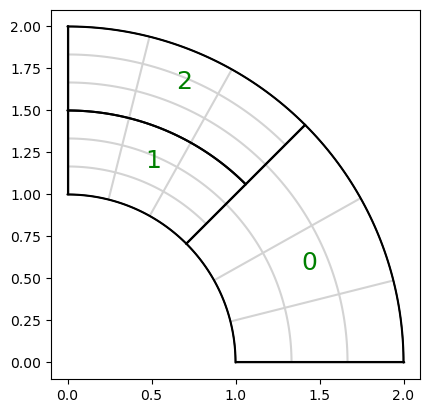

In [12]:
M.draw(knots=1, patch_idx=1)

In [125]:
corner = np.concatenate([assemble.boundary_dofs(kvs,m=0,ravel=True) + MP.N_ofs[p] for p, kvs in enumerate(MP.mesh.kvs)])
n = MP.B.shape[1]

In [115]:
idx = (MP.B[:,corner]>0).getnnz(1)>0
B = MP.B[idx,:]
B = B[B.getnnz(1)==2,:]
loc_c = np.unique(B.indices)
R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
c_B = B@R.T

R = scipy.sparse.coo_matrix((np.ones(len(loc_c)),(np.arange(len(loc_c)),loc_c)),shape=(len(loc_c),n)).tocsr()
nodal_indicator = algebra_cy.pyx_compute_basis(c_B.shape[0], c_B.shape[1], c_B, maxiter=5)
dofs = np.empty(nodal_indicator.shape[1], dtype=np.int32)
S = c_B.sum(0).A[0]
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    dofs[j]=R.indices[ind[np.argmax(S[ind])]]
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]
nnz = MP.B.getnnz(1)
B = MP.B.tocsc()
constr = np.repeat(-1,len(dofs))

for j in range(nodal_indicator.shape[1]):
    dof=dofs[j]
    for r in range(B.indptr[dof],B.indptr[dof+1]):
        i=B.indices[r]
        if nnz[i]>2:
            constr[j]=i
            break
if any(constr!=-1):
    idx = np.where(constr!=-1)[0]
    res = scipy.sparse.csc_matrix(nodal_indicator.shape)
    Q = scipy.sparse.spdiags(1*(constr!=-1),0,len(constr),len(constr))
    Q = scipy.sparse.coo_matrix((np.ones(len(idx)),(idx,np.arange(len(idx)))),(len(constr),len(idx)))
    res = (Q@abs(MP.B[constr[idx],:])).T
    res.data=abs(res.data-1)
    res.eliminate_zeros()
    nodal_indicator += res

In [116]:
np.array([nodal_indicator.indices, nodal_indicator.data])

array([[25.   , 20.   , 54.   , 24.   , 21.   , 22.   , 23.   , 50.   , 29.   , 70.   , 49.   ],
       [ 1.   ,  1.   ,  1.   ,  1.   ,  0.875,  0.25 ,  0.875,  1.   ,  1.   ,  1.   ,  1.   ]])

In [117]:
dofs= np.split(nodal_indicator.indices,nodal_indicator.indptr[1:-1])

In [118]:
coeffs =np.split(nodal_indicator.data,nodal_indicator.indptr[1:-1])

In [119]:
list(zip(dofs,coeffs))

[(array([25, 20], dtype=int32), array([1., 1.])),
 (array([54, 24], dtype=int32), array([1., 1.])),
 (array([21, 22, 23, 50, 29], dtype=int32),
  array([0.875, 0.25 , 0.875, 1.   , 1.   ])),
 (array([70, 49], dtype=int32), array([1., 1.]))]

In [17]:
nodal_indicator.indices[nodal_indicator.indptr[:-1]]

array([ 3, 12, 31, 32, 35], dtype=int32)

In [8]:
print(nodal_indicator[:,2])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (64, 1)>
  Coords	Values
  (31, 0)	1.0
  (44, 0)	1.0


In [258]:
idx=np.where(constr!=-1)[0]

In [259]:
idx

array([2])

In [270]:
res = scipy.sparse.csc_matrix(nodal_indicator.shape)

In [274]:
res[:,idx]=abs(MP.B[constr[idx],:]).T

/home/wolfman/miniforge3/lib/python3.11/site-packages/scipy/sparse/_index.py:142: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_arrayXarray_sparse(i, j, x)


In [280]:
res.data=abs(res.data-1)

In [282]:
res.data

array([0.5, 0.5, 0. ])

In [272]:
abs(MP.B[constr[idx],:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3 stored elements and shape (1, 81)>

In [273]:
res[:,idx]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 0 stored elements and shape (81, 1)>

In [214]:
idx

array([-1, -1, -1, -1])

In [135]:
B.toarray()

array([[ 0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [120]:
np.argmax(np.array([-1,0,1]))

2

In [118]:
c_B[:,[2,4,6,10]].sum(0)

matrix([[-2.,  0.,  0.,  2.]])

In [92]:
nodal_indicator = (R.T@nodal_indicator)[:,nodal_indicator.getnnz(axis=0)>1]

In [88]:
c_B

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (4, 8)>

In [86]:
for j in range(nodal_indicator.shape[1]):
    ind = nodal_indicator.indices[nodal_indicator.indptr[j]:nodal_indicator.indptr[j+1]]
    

# dofs = nodal_indicator.indices
# nnz = MP.B.getnnz(1)
# B = MP.B.tocsc()
# idx = np.zeros(len(dofs))-1

# for k,dof in enumerate(dofs):
#     for r in range(B.indptr[dof],B.indptr[dof+1]):
#         i = B.indices[r]
#         if nnz[i]>2 and np.isclose(B.data[r],1): 
#             idx[k] = i
# #idx = MP.Constr[:,dofs].tocsc().indices
# #nnz = MP.Constr.getnnz(1)

[12 16]
[15 35]
[19 32]
[31 44]


In [87]:
ind

array([31, 44], dtype=int32)

In [82]:
dofs

array([12, 16, 15, 35, 19, 32, 31, 44], dtype=int32)

In [83]:
B[:,dofs].toarray()

array([[-1. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. , -1. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -0.5,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. , -1. ,  1. ,  0. ,  0. ,  0. ,  0. ]])

In [84]:
idx

array([-1., -1., -1., -1.,  3.,  8., -1., -1.])

In [54]:
print(B[:,12])

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 2 stored elements and shape (12, 1)>
  Coords	Values
  (0, 0)	-1.0
  (1, 0)	-0.5


In [25]:
B.indices[B.indptr[dofs[2]]:B.indptr[dofs[2]+1]]

array([3, 4], dtype=int32)

In [84]:
idx = MP.Constr[:,dofs].tocsc().indices

In [26]:
B[:,dofs].toarray()

array([[1., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 1., 0., 0.]])

In [75]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [74]:
nnz

array([2, 3, 2, 3, 2, 2, 2, 2, 3, 2, 3, 2], dtype=int32)

In [31]:
dofs

array([16, 35, 32, 44], dtype=int32)

In [41]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,

In [19]:
idx1 = MP.Constr.tocsc()[:,dofs].getnnz(1)>0

In [20]:
idx1

array([ True, False, False, False,  True, False, False,  True,  True, False, False,  True])

In [248]:
B = MP.Constr[idx,:]

In [249]:
B.toarray()

array([[ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -1. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  1. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. , -0.5, -0.5,  0. ,  0. ,

In [250]:
MP.Constr[idx,:][MP.Constr[idx,:].getnnz(1)>0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 11 stored elements and shape (5, 48)>

In [251]:
nodal_indicator.indptr[:-1]

array([0, 2, 4, 6], dtype=int32)

In [252]:
np.where(idx2)

(array([1, 2, 3, 4, 5]),)

In [126]:
idx2=np.unique(1*((MP.Constr@R.T@R)==1).tocsc().indices)
corner_dofs = np.unique(MP.Constr[idx2,:].indices)

In [127]:
corner_dofs

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [125]:
np.unique(MP.Constr[idx2,:].indices)

array([12, 13, 14, 15, 16, 19, 31, 32, 38, 74], dtype=int32)

In [73]:
MP.Constr.data

array([-1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. , -0.5, -0.5,  1. , -1. ,  1. ])

In [44]:
MP.Constr.data[MP.Constr.data==-1]=0

In [47]:
MP.Constr[:,loc_c]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 12 stored elements and shape (12, 12)>

In [45]:
MP.Constr[:,loc_c]+1*(MP.Constr[:,loc_c]!=0)

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (12, 12)>

In [30]:
idx2 = (MP.Constr[:,loc_c].getnnz(axis=1)>0)

In [32]:
np.where(idx2)

(array([ 0,  1,  3,  4,  7,  8, 10, 11]),)

In [37]:
print((abs(MP.Constr)-1*(MP.Constr!=0))[idx2,:])

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 8 stored elements and shape (8, 48)>
  Coords	Values
  (1, 12)	-0.5
  (1, 13)	-0.5
  (2, 13)	-0.5000000000000001
  (2, 14)	-0.5
  (5, 13)	-0.5000000000000001
  (5, 14)	-0.5
  (6, 14)	-0.4999999999999999
  (6, 15)	-0.5000000000000002


In [27]:
np.where(idx)

(array([ 0,  4,  7, 11]),)

In [385]:
c_Basis

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 16 stored elements and shape (36, 9)>

In [386]:
c_Basis[:,c_Basis.getnnz(axis=0)>1]

<Compressed Sparse Column sparse matrix of dtype 'float64'
	with 12 stored elements and shape (36, 5)>

In [387]:
dofs = c_Basis[:,c_Basis.getnnz(axis=0)>1].indices

In [388]:
sec = c_Basis[:,c_Basis.getnnz(axis=0)>1].indptr

In [389]:
dofs

array([27,  2,  9,  6, 24, 17, 33, 18, 11,  8, 35, 20], dtype=int32)

In [390]:
sec

array([ 0,  2,  4,  6, 10, 12], dtype=int32)

In [391]:
np.split(dofs, sec[1:-1])

[array([27,  2], dtype=int32),
 array([9, 6], dtype=int32),
 array([24, 17], dtype=int32),
 array([33, 18, 11,  8], dtype=int32),
 array([35, 20], dtype=int32)]

In [19]:
# x = np.zeros(n)
# x[loc_c] = 1
# R = scipy.sparse.spdiags(x,0,n,n)
# B_ = MP.Constr@R

In [20]:
#fine_dofs = np.unique((B_==1).tocsr().indices)

In [21]:
#np.unique(fine_dofs)

In [22]:
#idx2 = np.unique(MP.Constr[:,fine_dofs].tocsc().indices)

In [23]:
#B = MP.Constr[idx2,:]

In [24]:
#B[B.getnnz(1)>2].toarray()

In [25]:
Basis = algebra_cy.pyx_compute_basis(B.shape[0], B.shape[1], B, maxiter=5).tocsc()

In [26]:
Basis = Basis[:,Basis.getnnz(axis=0)>1]

In [27]:
Basis.shape

(48, 5)

In [28]:
Basis.toarray()

array([[0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 1. , 0. , 0. , 0. ],
       [0. , 0. , 1. , 0. , 0. ],
       [0. , 0. , 0. , 1. , 0. ],
       [1. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0.5, 0.5, 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0. , 0. , 0. , 0. ],
       [0. , 0

In [450]:
fine_dofs = Basis.indices[Basis.indptr[:-1]]

In [235]:
sys.setrecursionlimit(100000)
N = 1000
A = np.random.rand(N,N)
L = 10000*[aslinearoperator(A)]
S = np.array(L).sum()
x = np.random.rand(N)

In [236]:
%timeit S@x

550 ms ± 110 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [237]:
X = SumOperator(L)

In [238]:
%timeit X@x

505 ms ± 18.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [221]:
X

<3x2 SumOperator with dtype=int64>

In [154]:
L[0].dtype

dtype('int64')

In [140]:
np.all((np.array([s.shape for s in L])-np.tile(L[0].shape,len(L)).reshape(-1,2))==0)

True

In [198]:
class SumOperator(scipy.sparse.linalg.LinearOperator):
    """A :class:`LinearOperator` which implements the 
    application of an arbitrary sum of given input operators 
    without(!) using recursive structures.
    """
    def __init__(self, ops):
        self.N = len(ops)
        assert np.all((np.array([op.shape for op in ops])-np.tile(ops[0].shape,self.N).reshape(-1,2))==0)
        self.ops = ops
        self.shape = ops[0].shape
        scipy.sparse.linalg.LinearOperator.__init__(self, ops[0].dtype, self.shape)
        
    def _matvec(self, x):
        return np.array([op@x for op in self.ops]).sum(axis=0)

    def _transpose(self):
        return SumOperator([op.T for op in self.ops])
        

In [128]:
np.all(np.array([1,1,1])==1)

True

In [136]:
np.tile(L[0].shape,len(L)).reshape(-1,2)

array([[3, 2],
       [3, 2],
       [3, 2]])